# Crossmatching Catalogs

## Learning Objectives

At the end of this tutorial, you will understand:

- how to test a crossmatch by limiting inputs with cone searches and column selection
- how to crossmatch objects between two catalogs by `ra` and `dec`
- the importance of margin caches when crossmatching, and the default margin caches

You should already have an understanding of:

- how to open a catalog

## Introduction

To crossmatch two catalogs is to create a new catalog that contains columns from both inputs, with the rows aligned based on the geometric match of their `ra` and `dec` columns.

In [1]:
import lsdb
from dask.distributed import Client

## 1. Open a catalog

We create a basic dask client, and open an existing HATS catalog—the ZTF DR14 catalog.

Create a basic Dask client, limiting the number of workers. This keeps subsequent operations from using more of our compute resources than we might intend, which is helpful in any case but especially when working on a shared resource.

In [2]:
client = Client(n_workers=4, memory_limit="auto")
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 39.27 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54384,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 39.27 GiB
Comm: tcp://127.0.0.1:54395,Total threads: 3
Dashboard: http://127.0.0.1:54398/status,Memory: 9.82 GiB
Nanny: tcp://127.0.0.1:54387,


We open two catalogs, ZTF DR22 and Gaia DR3.  Both of these are catalog *collections* on http://data.lsdb.io, and each of them has a default margin cache catalog that is implicitly loaded.  The margin cache is important for crossmatching, as it will help with cases when objects of interest are right at the edge of the catalog pixels.

In [3]:
ztf22 = lsdb.open_catalog(
    "https://data.lsdb.io/hats/ztf_dr22",
)

gaia3 = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_dr3",
)

In [4]:
display(ztf22.columns)
display(gaia3.columns)

Index(['objectid', 'filterid', 'fieldid', 'rcid', 'objra', 'objdec', 'nepochs',
       'hmjd', 'mag', 'magerr', 'clrcoeff', 'catflags', 'Norder', 'Dir',
       'Npix'],
      dtype='object')

Index(['solution_id', 'designation', 'source_id', 'ref_epoch', 'ra',
       'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pm',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_n_obs',
       'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag',
       'phot_bp_n_obs', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error',
       'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux',
       'phot_rp_mean_flux_error', 'phot_rp_mean_mag'],
      dtype='object')

### 1.1 Will these catalogs have any overlap at all?

To find an area of the sky where we know that crossmatching will succeed, we can use `.plot_pixels()` to get a quick view of the sky coverage for each catalog.

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - ztf_lc'}>)

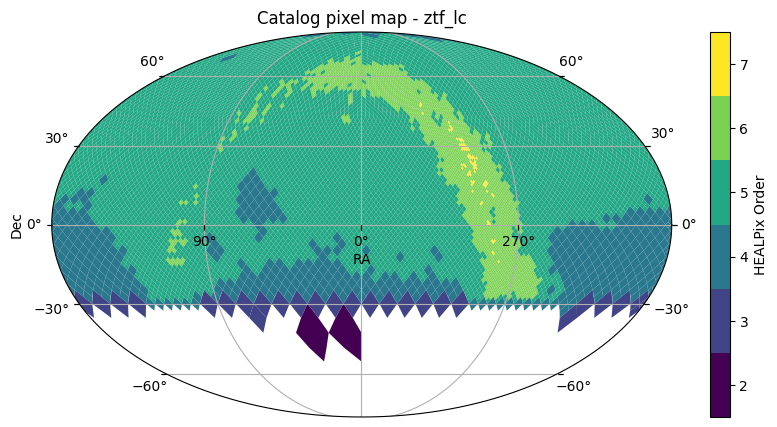

In [5]:
ztf22.plot_pixels()

(<Figure size 1000x500 with 2 Axes>,
 <WCSAxes: title={'center': 'Catalog pixel map - gaia'}>)

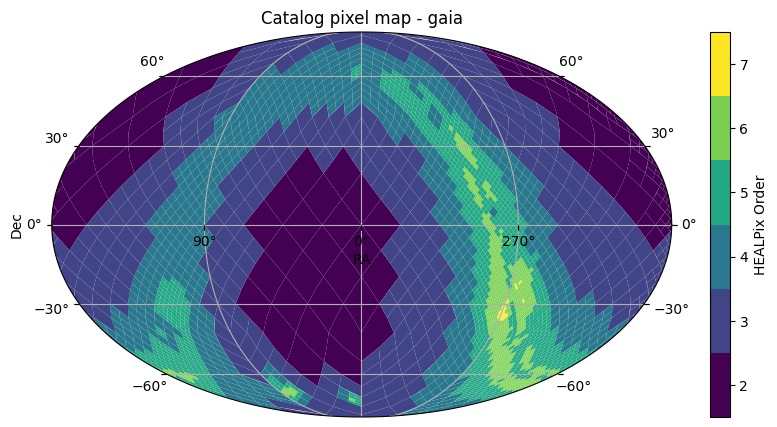

In [6]:
gaia3.plot_pixels()

Yes, looks like they will, above `dec=-30`.

### 1.2 Work with small sections of the catalogs first

Before firing up the whole compute cluster to match both catalogs, it's good practice to choose a small
section of each catalog first, greatly limiting both I/O and compute.  We can limit *spatially* by using
a search filter such as a cone search or box search, and can limit *structurally* by only loading
columns of interest.

Let's use a cone search to isolate a tiny part of both catalogs in the same area, so that we can test our crossmatch.  We'll set the search filters of both catalogs to `lsdb.ConeSearch(280, 0, radius_arcsec=36)`.

We'll use the suffix `_sm` (small) to distinguish these from the full catalog.

In [7]:
ztf22_sm = lsdb.open_catalog(
    "https://data.lsdb.io/hats/ztf_dr22",
    columns=["objectid", "objra", "objdec", "nepochs", "hmjd", "mag", "magerr"],
    search_filter=lsdb.ConeSearch(280, 0, radius_arcsec=36),
)
ztf22_sm

,objectid,objra,objdec,nepochs,hmjd,mag,magerr
npartitions=1,,,,,,,
"Order: 6, Pixel: 30357",int64[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],list<element: double>[pyarrow],list<element: float>[pyarrow],list<element: float>[pyarrow]


### 1.3 Nesting columns with list data

Note that ZTF DR22 has lightcurve data stored as lists under each column.  To access and crossmatch these efficiently, we will use `.nest_lists` to arrange these lists into a single "nest" in the catalog.

Three of the loaded columns in `ztf_lc` are of type `list`, so let's put those lists into a nest
named `lc`, to make them more tractable.

In [8]:
ztf22_sm = ztf22_sm.nest_lists(
    list_columns=["hmjd", "mag", "magerr"],
    name="lc",
)
ztf22_sm

,objectid,objra,objdec,nepochs,lc
npartitions=1,,,,,
"Order: 6, Pixel: 30357",int64[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [..."


This small version, which we call `ztf22_sm`, occupies only one partition.
Pulling this into memory with `.compute()` won't take too long.

We're interested in seeing how many *objects* are in our chosen cone search.
The catalog identifiers for ZTF (`objectid`) and Gaia (`source_id`) are unique,
one row for each, so the count of rows tells us the number of objects.

In [9]:
%%time
ztf_cone_objs = ztf22_sm["objectid"].compute()
print("Unique ZTF objects in the cone:", len(ztf_cone_objs))

Unique ZTF objects in the cone: 129
CPU times: user 2.91 s, sys: 1.03 s, total: 3.94 s
Wall time: 31.1 s


### 1.4 Viewing the objects within the cone searches

We can plot these points graphically:

CPU times: user 2.87 s, sys: 975 ms, total: 3.84 s
Wall time: 29.4 s


(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the ztf_lc catalog'}>)

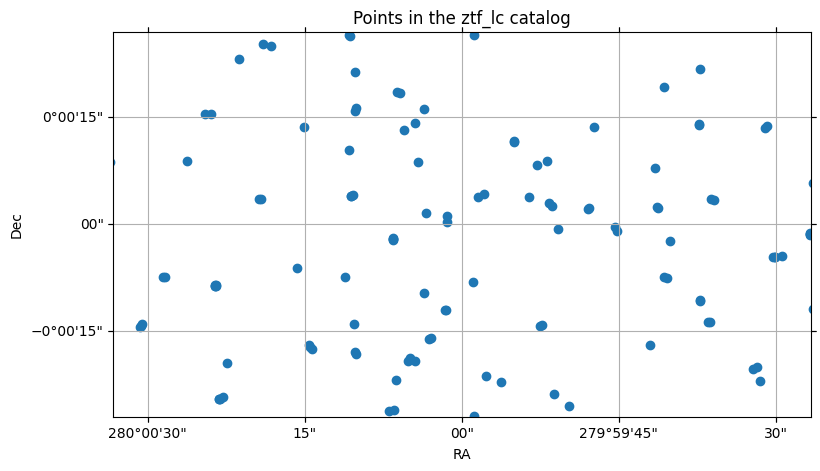

In [10]:
%%time
from astropy.coordinates import SkyCoord
import astropy.units as u

# Center our view on the cone.
center = SkyCoord(280 * u.deg, 0 * u.deg)
fov = (1 * u.arcmin, 1 * u.arcmin)

ztf22_sm.plot_points(center=center, fov=fov)

Now let's treat the Gaia catalog the same way, using the same small cone search, and
selecting only a few columns of interest.  Again, we'll use the suffix `_sm` for "small":

In [11]:
gaia3_sm = lsdb.open_catalog(
    "https://data.lsdb.io/hats/gaia_dr3",
    columns=["source_id", "ra", "dec", "parallax", "phot_g_n_obs", "phot_g_mean_mag"],
    search_filter=lsdb.ConeSearch(280, 0, radius_arcsec=36),
)
gaia3_sm

,source_id,ra,dec,parallax,phot_g_n_obs,phot_g_mean_mag
npartitions=1,,,,,,
"Order: 5, Pixel: 7589",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow]


In [12]:
%%time
gaia_cone_objs = gaia3_sm["source_id"].compute()
print("Unique Gaia sources in the cone:", len(gaia_cone_objs))

Unique Gaia sources in the cone: 17
CPU times: user 469 ms, sys: 178 ms, total: 647 ms
Wall time: 4.79 s


CPU times: user 470 ms, sys: 153 ms, total: 623 ms
Wall time: 4.92 s


(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the gaia catalog'}>)

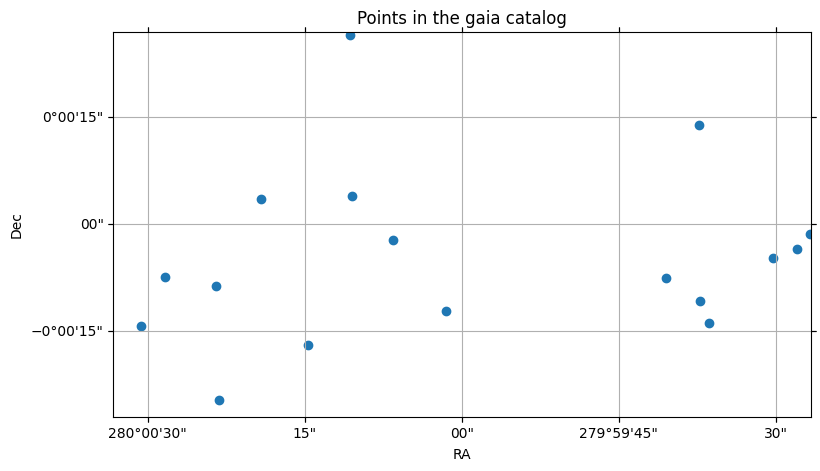

In [13]:
%%time
gaia3_sm.plot_points(center=center, fov=fov)

We can see that the Gaia catalog is much more sparse than the ZTF catalog, having
almost a tenth of the objects for the same area of the sky.

## 2. Perform the crossmatch on the small catalogs

The default crossmatch algorithm is the `KdTreeCrossmatch`, and it is performed in a manner similar
to an inner join, in that the resulting catalog will only have rows containing objects that exist
in both catalogs.  This also means that only pixels common to both catalogs are used in the crossmatch;
you don't need to arrange this yourself.

### 2.1 Effect of ordering on crossmatching

However, this doesn't mean that the order of the catalogs doesn't matter.  As we'll see,
`gaia X ztf` gives us different results than `ztf X gaia`, even though the unique objects
from the two catalogs participating in the crossmatch remain the same.

The algorithm takes each object in the left catalog and finds the closest spatial match
from the right catalog.

If the left catalog is *denser*, this means that we are more likely to have objects from the
left matching the same object on the right, giving us more rows.  If the left catalog is
*sparser*, we are more likely to have objects in the left with no matches on the right, and
therefore the result may have fewer rows, as in the next example.

#### 2.1.1 gaia X ztf (sparser on the left)

We'll start by matching Gaia against ZTF, or `gaia X ztf`.  Note that `gaia_x_ztf` will be the
uncomputed catalog, and we'll use the prefix `c_`, or `c_gaia_x_ztf` to indicate the computed
result.  The computed result from this small crossmatch will fit easily in memory, and it will
be a `NestedFrame`.

In [14]:
%%time
gaia_x_ztf = gaia3_sm.crossmatch(ztf22_sm)
c_gaia_x_ztf = gaia_x_ztf.compute()
c_gaia_x_ztf

CPU times: user 4.51 s, sys: 1.2 s, total: 5.71 s
Wall time: 36.7 s


source_id_gaia     ra_gaia  dec_gaia  parallax_gaia  \
_healpix_29                                                                     
2136230505053742297  4272460980177200768  280.000432 -0.003361       0.306259   
2136230505911963019  4272460980182044416   279.99345 -0.003846           <NA>   
2136230507990852146  4272461018841217920  280.006446 -0.006851      -0.070988   
2136230510106305823  4272461018829177728  280.004081 -0.004709      -0.233567   
2136230510539474332  4272461018841218432  280.008516 -0.003975      -0.642788   
2136230511149475917  4272461014544179712  280.007883 -0.002041       0.824229   
2136230511175473210  4272461018841219072   280.00653 -0.002397       0.474788   
2136230517889181962  4272461014537456000  280.005341  0.000974       0.752347   
2136230518300361978  4272461014536964480   280.00182 -0.000606       0.135197   
2136230519233834902  4272461014537456128  280.002917  0.001124      -0.132673   
2136230529035689243  4272461053196344192  279.993671 -0.003003           <NA>   
2136230529701272945  4272461048901519744   279.99174 -0.001291      -0.594373   
2136230529826095643  4272461048901521792  279.994575 -0.002093           <NA>   
2136230531211565092  4272461048896704384  279.990748 -0.000366       0.739992   
2136230544329985725  4272461083261768448  279.993694  0.003887           <NA>   
2136230546741664796  4272461083261774336  280.002972  0.007368       0.164828   

                     phot_g_n_obs_gaia  phot_g_mean_mag_gaia  \
_healpix_29                                                    
2136230505053742297                102             20.670609   
2136230505911963019                 61                20.738   
2136230507990852146                164             20.329275   
2136230510106305823                147             20.310305   
2136230510539474332                126             20.438658   
2136230511149475917                 93             20.665417   
2136230511175473210                179             15.848508   
2136230517889181962                173             19.777922   
2136230518300361978                175              18.72089   
2136230519233834902                151             19.814991   
2136230529035689243                 42              20.89644   
2136230529701272945                186             18.847134   
2136230529826095643                 89             20.573746   
2136230531211565092                182             17.559347   
2136230544329985725                 61             20.664341   
2136230546741664796                156             20.154015   

                      objectid_ztf_lc  objra_ztf_lc  objdec_ztf_lc  \
_healpix_29                                                          
2136230505053742297   435213300004409    280.000427      -0.003351   
2136230505911963019   435313300048086    279.993469      -0.003805   
2136230507990852146  1481208400000483    280.006409      -0.006818   
2136230510106305823   435213300027218    280.004059      -0.004711   
2136230510539474332   435213300004426    280.008514      -0.003947   
2136230511149475917   435313300153496    280.007874      -0.002036   
2136230511175473210   435313300083253    280.006531      -0.002385   
2136230517889181962   435213300004315    280.005341       0.000983   
2136230518300361978   435313300008254    280.001831      -0.000595   
2136230519233834902   435213300045612     280.00293       0.001121   
2136230529035689243   435313300048085    279.993683      -0.002992   
2136230529701272945   435313300048022     279.99173      -0.001263   
2136230529826095643   435313300048051    279.994568      -0.002079   
2136230531211565092   435313300083184    279.990753      -0.000369   
2136230544329985725   435213300004249    279.993713       0.003882   
2136230546741664796   435313300047734    280.002991       0.007368   

                     nepochs_ztf_lc  \
_healpix_29                           
2136230505053742297             100   
2136230505911963019             144 

Note that the crossmatch catalog's columns include:

  * all the columns from Gaia, suffixed with `_gaia`
  * all the columns from ZTF, suffixed with `_ztf_lc`
  * a new column, `_dist_arcsec`, which gives the shortest (great circle) distance between the two matched objects in each row, in arcseconds
  
**NOTE:** The catalog identifiers `gaia` and `ztf_lc` come from the `.name` properties of the two input catalogs.  The `suffixes=` argument of `.crossmatch` can be used to override these.

In [15]:
c_gaia_x_ztf["_dist_arcsec"].sort_values()

_healpix_29
2136230519233834902    0.019936
2136230546741664796    0.020014
2136230505053742297    0.038935
2136230510106305823    0.040958
2136230511175473210    0.043069
2136230518300361978     0.05034
2136230531211565092    0.059375
2136230517889181962    0.059946
2136230511149475917    0.061448
2136230529826095643     0.06879
2136230529035689243    0.074194
2136230544329985725    0.075677
2136230510539474332    0.105025
2136230529701272945    0.121662
2136230507990852146    0.155598
2136230505911963019      0.1623
Name: _dist_arcsec, dtype: double[pyarrow]

Earlier, we plotted the points for both of the input catalogs.  We can plot the points of the output
catalog, now, to see how well the crossmatch aligned.  Since each row contains the combination of columns
from both input catalogs, each row includes the (ra, dec) points from each source catalog,
for each row representing a match.

In our case, this means `(ra_gaia, dec_gaia)` and `(objra_ztf_lc, objdec_ztf_lc)`.

**NOTE:** we are using the *catalog objects*, not the *computed results*, for the plotting, because `.plot_points()`
is a method on the catalog, not on the `NestedFrame`.


CPU times: user 6.52 s, sys: 2.05 s, total: 8.57 s
Wall time: 1min 6s


(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the gaia_x_ztf_lc catalog'}>)

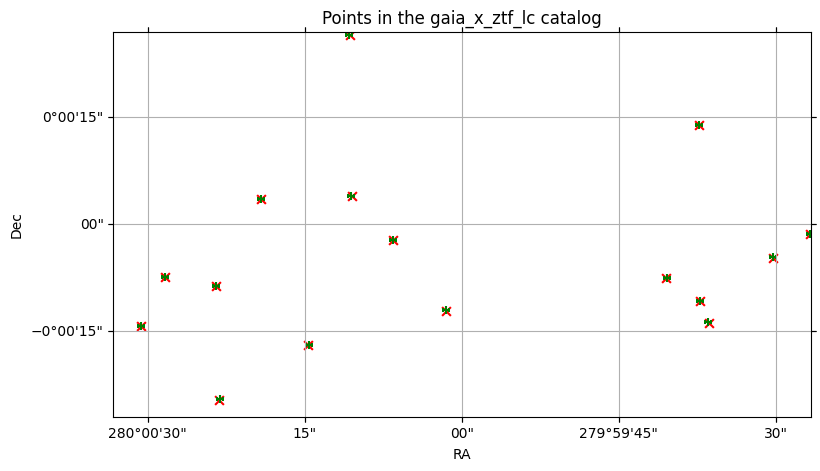

In [16]:
%%time

# First the Gaia points
gaia_x_ztf.plot_points(
    ra_column="ra_gaia",
    dec_column="dec_gaia",
    center=center,
    fov=fov,
    c="red",
    marker="x",
    s=40,
    label="gaia points",
)

gaia_x_ztf.plot_points(
    ra_column="objra_ztf_lc",
    dec_column="objdec_ztf_lc",
    # Can skip the center & fov args here, since this is an overlay
    c="green",
    marker="+",
    s=30,
    label="ztf points",
)

#### 2.1.2 ztf X gaia (denser on the left)

Now let's crossmatch the same catalogs, but switching the left and right catalog.  Now we have the
denser catalog on the left.

The algorithm is, in pseudocode:

```
for every point in the left catalog:
    find the closest match in the right catalog
```

When there are more points in the left catalog than in the right, as in this case, each object in
the right catalog will get matched to more than one object in the left.

In [17]:
ztf_x_gaia = ztf22_sm.crossmatch(gaia3_sm)
ztf_x_gaia

,objectid_ztf_lc,objra_ztf_lc,objdec_ztf_lc,nepochs_ztf_lc,lc_ztf_lc,source_id_gaia,ra_gaia,dec_gaia,parallax_gaia,phot_g_n_obs_gaia,phot_g_mean_mag_gaia,_dist_arcsec
npartitions=1,,,,,,,,,,,,
"Order: 6, Pixel: 30357",int64[pyarrow],float[pyarrow],float[pyarrow],int64[pyarrow],"nested<hmjd: [double], mag: [float], magerr: [...",int64[pyarrow],double[pyarrow],double[pyarrow],double[pyarrow],int64[pyarrow],double[pyarrow],double[pyarrow]


In [18]:
%%time
c_ztf_x_gaia = ztf_x_gaia.compute()
c_ztf_x_gaia

CPU times: user 2.75 s, sys: 797 ms, total: 3.55 s
Wall time: 27.9 s


objectid_ztf_lc  objra_ztf_lc  objdec_ztf_lc  \
_healpix_29                                                         
2136230505053800416  435313300083261    280.000458      -0.003345   
2136230505053837760  435213300004409    280.000427      -0.003351   
...                              ...           ...            ...   
2136230546738860188  435213300026969     280.00296       0.007355   
2136230546740271548  435313300047734    280.002991       0.007368   

                     nepochs_ztf_lc  \
_healpix_29                           
2136230505053800416             155   
2136230505053837760             100   
...                             ...   
2136230546738860188             402   
2136230546740271548             167   

                                                             lc_ztf_lc  \
_healpix_29                                                              
2136230505053800416  [{hmjd: 58955.48525, mag: 19.895302, magerr: 0...   
2136230505053837760  [{hmjd: 58280.34025, mag: 21.346365, magerr: 0...   
...                                                                ...   
2136230546738860188  [{hmjd: 58217.48498, mag: 20.79632, magerr: 0....   
2136230546740271548  [{hmjd: 58955.48525, mag: 19.320301, magerr: 0...   

                          source_id_gaia     ra_gaia  dec_gaia  parallax_gaia  \
_healpix_29                                                                     
2136230505053800416  4272460980177200768  280.000432 -0.003361       0.306259   
2136230505053837760  4272460980177200768  280.000432 -0.003361       0.306259   
...                                  ...         ...       ...            ...   
2136230546738860188  4272461083261774336  280.002972  0.007368       0.164828   
2136230546740271548  4272461083261774336  280.002972  0.007368       0.164828   

                     phot_g_n_obs_gaia  phot_g_mean_mag_gaia  _dist_arcsec  
_healpix_29                                                                 
2136230505053800416                102             20.670609        0.1264  
2136230505053837760                102             20.670609      0.038935  
...                                ...                   ...           ...  
2136230546738860188                156             20.154015       0.09216  
2136230546740271548                156             20.154015      0.020014  

[47 rows x 12 columns]

47 matches in this case, vs 16 matches in the first case.  Let's look at the plot again:

CPU times: user 3.82 s, sys: 1.34 s, total: 5.16 s
Wall time: 55.7 s


(<Figure size 900x500 with 1 Axes>,
 <WCSAxes: title={'center': 'Points in the ztf_lc_x_gaia catalog'}>)

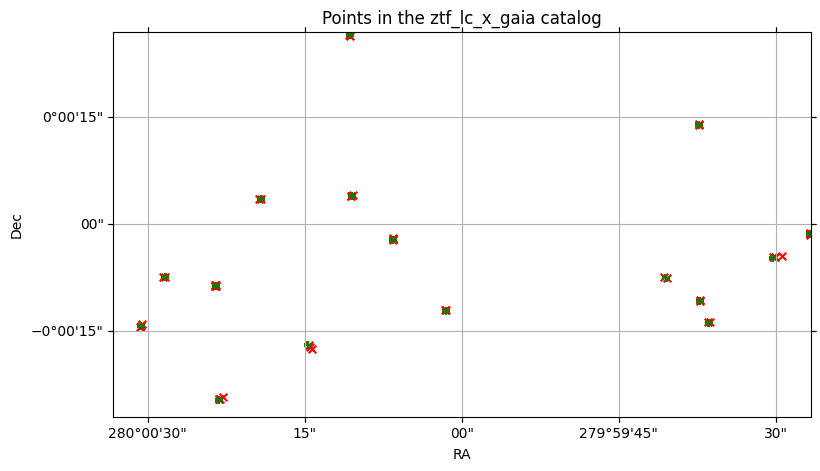

In [19]:
%%time

# First the ZTF points
ztf_x_gaia.plot_points(
    ra_column="objra_ztf_lc",
    dec_column="objdec_ztf_lc",
    center=center,
    fov=fov,
    c="red",
    marker="x",
    s=30,
    label="ztf points",
)

# Then the Gaia points
ztf_x_gaia.plot_points(
    ra_column="ra_gaia",
    dec_column="dec_gaia",
    # Can skip the center & fov args here, since this is an overlay
    c="green",
    marker="+",
    s=40,
    label="gaia points",
)

There are several red `x` markers (left) for each green `+` marker (right).

And yet, out of the 129 points in the ZTF cone, only 47 of those could be considered matches at all;
the other 82 aren't even candidates.

### 2.2 Effect of `n_neighbors` on number of results

One of the arguments to `.crossmatch` is `n_neighbors`, which defaults to `1`, meaning that for each
object in the left catalog, we're looking for one best match from the right catalog.

But we can look for more than one best match.  By increasing this argument, we can get gaia X ztf to
produce the same results as ztf X gaia.

In [20]:
gaia_x_ztf_n10 = gaia3_sm.crossmatch(ztf22_sm, n_neighbors=10)
c_gaia_x_ztf_n10 = gaia_x_ztf_n10.compute()
len(c_gaia_x_ztf_n10)

47

47 results, just like ztf x gaia with `n_neighbors=1`.

### 2.3 Verifying object identifiers

Converting the catalog identifiers from the crossmatches to Python sets makes it easy to
verify that we've got not only the right count but the same results.  We're showing that
the computed gaia X ztf crossmatch with 10 neighbors produces the same set of results
as the computed ztf X gaia crossmatch with 1 neighbor.

In [21]:
gaia_x_ztf_n10_pairs = set(c_gaia_x_ztf_n10[["source_id_gaia", "objectid_ztf_lc"]])
print("Number of unique matching pairs in gaia X ztf, using 10 neighbors:", len(gaia_x_ztf_n10_pairs))
ztf_x_gaia_n1_pairs = set(c_ztf_x_gaia[["source_id_gaia", "objectid_ztf_lc"]])
print("Number of unique matching pairs in ztf X gaia, using 1 neighbor:", len(ztf_x_gaia_n1_pairs))

Number of unique matching pairs in gaia X ztf, using 10 neighbors: 2
Number of unique matching pairs in ztf X gaia, using 1 neighbor: 2


In [22]:
# Check that the content of both sets is the same
gaia_x_ztf_n10_pairs == ztf_x_gaia_n1_pairs

True

## Closing the Dask client

In [23]:
client.close()

## About

**Authors**: Derek Jones

**Last updated on**:  June 4, 2025

If you use `lsdb` for published research, please cite following [instructions](https://docs.lsdb.io/en/stable/citation.html).